<a href="https://colab.research.google.com/github/tanyagupta1/Machine-Learning/blob/main/DL/saving_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

In [2]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

In [3]:
(train_examples,validation_examples),info=tfds.load('cats_vs_dogs',split=['train[:50%]', 'train[50%:]'],with_info=True,as_supervised=True)

In [4]:
def format_image(image,label):
  image=tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image,label
num_examples=info.splits['train'].num_examples
BATCH_SIZE=32
IMAGE_RES=224
train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [5]:
URL="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor=hub.KerasLayer(URL,input_shape=(IMAGE_RES,IMAGE_RES,3))

In [6]:
feature_extractor.trainable=False

model=tf.keras.Sequential([feature_extractor,layers.Dense(2,activation='softmax')])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',metrics=['accuracy'],loss=tf.losses.SparseCategoricalCrossentropy())
EPOCHS=1
model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

In [8]:
class_names=np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [14]:
image_batch,label_batch=next(iter(train_batches.take(1)))
image_batch=image_batch.numpy()
label_batch=label_batch.numpy()

predicted_batch=model.predict(image_batch)
predicted_batch=tf.squeeze(predicted_batch).numpy()
predicted_ids=np.argmax(predicted_batch,axis=-1)
predicted_class_names=class_names[predicted_ids]
print(predicted_class_names)
print(class_names[label_batch])

['cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog' 'dog'
 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog'
 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog']
['cat' 'dog' 'dog' 'dog' 'cat' 'dog' 'dog' 'cat' 'dog' 'dog' 'dog' 'dog'
 'cat' 'dog' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'dog' 'dog' 'dog' 'dog'
 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'dog']


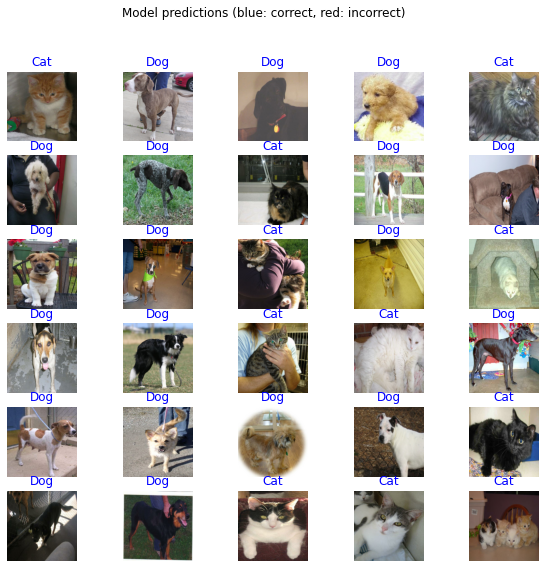

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

**Saving model**

In [16]:
t=time.time()
export_path_keras="./{}.h5".format(int(t))
model.save(export_path_keras)
export_path_keras

'./1627032821.h5'

**Reload saved model**

In [23]:
reloaded=tf.keras.models.load_model(export_path_keras,custom_objects={'KerasLayer':hub.KerasLayer})
reloaded.summary()
result_batch=model.predict(image_batch)
reloaded_result_batch=reloaded.predict(image_batch)
print(abs(result_batch-reloaded_result_batch).max())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
0.0


**Export as Saved Model**
<br>
SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:
*   A TensorFlow checkpoint containing the model weights.
*   A SavedModel proto containing the underlying Tensorflow graph. 
*   Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
*  The model's architecture config, if available.




In [19]:
t=time.time()
export_path_sm="./{}".format(int(t))
tf.saved_model.save(model,export_path_sm)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./1627033487/assets


INFO:tensorflow:Assets written to: ./1627033487/assets


In [25]:
reloaded_sm=tf.saved_model.load(export_path_sm)
reloaded_sm_result_batch=reloaded_sm(image_batch,training=False).numpy()
print(abs(result_batch-reloaded_sm_result_batch).max())

0.0


The object returned by tf.saved_model.load is not a Keras object (i.e. doesn't have .fit, .predict, .summary, etc. methods). Therefore, you can't simply take your reloaded_sm model and keep training it by running .fit. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the tf.keras.models.load_model function. 

In [27]:
reloaded_sm_keras=tf.keras.models.load_model(export_path_sm,custom_objects={'KerasLayer':hub.KerasLayer})
reloaded_sm_keras_result_batch = reloaded_sm_keras.predict(image_batch)
print((result_batch-reloaded_sm_keras_result_batch).max())

0.0
